<a href="https://colab.research.google.com/github/jenboland/DailyKnowledge/blob/master/PYMC_Spend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Version in this version we removed the time varying media and intercept. We used google trends data (consumer demand) for trend and we updated control variable to Oct, Nov, and Dec.

In [1]:
!pip install git+https://github.com/pymc-labs/pymc-marketing.git

  Cloning https://github.com/pymc-labs/pymc-marketing.git to /tmp/pip-req-build-o1krymwl
  Running command git clone --filter=blob:none --quiet https://github.com/pymc-labs/pymc-marketing.git /tmp/pip-req-build-o1krymwl
  Resolved https://github.com/pymc-labs/pymc-marketing.git to commit cf3eab2f979e76b175e02d51a6ad9f6b653a16a6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pymc-marketing: filename=pymc_marketing-0.11.1-py3-none-any.whl size=246192 sha256=44d3013e2fc52224caccaa3f582e053396ec5f635efbb94d53bd86e07f5c2e1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ltzilcb/wheels/74/4e/df/061764542e2335eb91488d930c91f3e06058325d53a008deb7
Successfully built pymc-marketing


In [2]:
!pip install numpyro


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.8/360.8 kB 10.7 MB/s eta 0:00:00


In [3]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import numpyro

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation, MichaelisMentenSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


In [4]:
import pymc_marketing
print(pymc_marketing.__version__)

0.11.1


In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path_ = "/content/drive/MyDrive/Colab Notebooks/"

In [8]:
bing = pd.read_csv(path_+'cafb_bing_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
dm = pd.read_csv(path_+'cafb_direct_mail_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
email = pd.read_csv(path_+'cafb_email_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
fb = pd.read_csv(path_+'cafb_facebook_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
paid_search = pd.read_csv(path_+'cafb_google_paid_search.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
prog = pd.read_csv(path_+'cafb_programmatic_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
sales = pd.read_csv(path_+'cafb_transactions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
#remove v2 from excel file name
ftf = pd.read_excel(path_+'CAFB MMM Telefundraising Data 2022-2024v2.xlsx', sheet_name = 'transposed', parse_dates=['timestamp']).fillna(0).rename(columns={'timestamp':'Date'}).set_index('Date').resample('W').sum()
ga4 = pd.read_csv(path_+'cafb_ga4_sessions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()

fb = fb.rename(columns={'Impressions':'FB_Impressions', 'Spend':'FB_Spend'})
ftf = ftf.rename(columns={'calls':'FTF_Impressions', 'funds':'FTF_Spend'})


In [9]:
consumer_demand = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='Consumer_Demand', index_col=None)
consumer_demand = consumer_demand.set_index('Date')
consumer_demand.head()

,Consumer_Demand
Date,
2022-01-02,0
2022-01-09,28
2022-01-16,24
2022-01-23,0
2022-01-30,24


In [10]:
df = pd.concat([bing, dm, email, fb, paid_search, prog, ftf ,sales, consumer_demand], axis=1).fillna(0).head(144).reset_index()
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

df.head(2)

,Date,Bing_Branded_Impressions,Bing_Branded_Spend,Bing_NonBranded_Impressions,Bing_NonBranded_Spend,DM_Spend,DM_Impressions,Email_Impressions,Email_Spend,FB_Spend,...,GoogleAds_Branded_Spend,GoogleAds_NonBranded_Impressions,GoogleAds_NonBranded_Spend,Programatic_Spend,Programatic_Impressions,FTF_Spend,FTF_Impressions,contacts,Revenue,Consumer_Demand
0,2022-01-02,1.0,3.26,3852.0,210.97,0.0,0.0,0.0,0.0,0.0,...,86.76,1365.0,196.73,0.0,0.0,0.0,0.0,0.0,44191.7,0.0
1,2022-01-09,64.0,8.25,4482.0,757.49,0.0,0.0,0.0,0.0,0.0,...,496.89,7085.0,1300.33,0.0,0.0,3036.0,6487.0,561.0,99989.5,28.0


In [11]:
df['GoogleAds_Impressions'] = df['GoogleAds_Branded_Impressions'] + df['GoogleAds_NonBranded_Impressions']
df['GoogleAds_Spend'] = df['GoogleAds_Branded_Spend'] + df['GoogleAds_NonBranded_Spend']

df['Bing_Impressions'] = df['Bing_Branded_Impressions'] + df['Bing_NonBranded_Impressions']
df['Bing_Spend'] = df['Bing_Branded_Spend'] + df['Bing_NonBranded_Spend']

In [12]:
#df["eoy_campaign"] = df["Date"].apply(lambda x: 1 if x.month in [11, 12] else 0)
#df["end_of_year"] = ((df["Date"].dt.month == 12) & (df["Date"].dt.day == 31)) | ((df["Date"].dt.month == 1) & (df["Date"].dt.day == 1))


In [13]:
df["october"] = df["Date"].apply(lambda x: 1 if x.month in [10] else 0)
df["november"] = df["Date"].apply(lambda x: 1 if x.month in [11] else 0)
df["december"] = df["Date"].apply(lambda x: 1 if x.month in [12] else 0)



In [14]:
#old way of doing trend, that is probably causing the model to overfit
#df['trend'] = df['Revenue'].shift(1).fillna(method="bfill")

df['google_trend'] = df['Consumer_Demand']

In [15]:
#df["month"] = df["Date"].dt.month  # values 1..12
#month_dummies = pd.get_dummies(df["month"], prefix="month")

#df = pd.concat([df, month_dummies], axis=1)


In [16]:
list(df)

['Date',
 'Bing_Branded_Impressions',
 'Bing_Branded_Spend',
 'Bing_NonBranded_Impressions',
 'Bing_NonBranded_Spend',
 'DM_Spend',
 'DM_Impressions',
 'Email_Impressions',
 'Email_Spend',
 'FB_Spend',
 'FB_Impressions',
 'GoogleAds_Branded_Impressions',
 'GoogleAds_Branded_Spend',
 'GoogleAds_NonBranded_Impressions',
 'GoogleAds_NonBranded_Spend',
 'Programatic_Spend',
 'Programatic_Impressions',
 'FTF_Spend',
 'FTF_Impressions',
 'contacts',
 'Revenue',
 'Consumer_Demand',
 'GoogleAds_Impressions',
 'GoogleAds_Spend',
 'Bing_Impressions',
 'Bing_Spend',
 'october',
 'november',
 'december',
 'google_trend']

In [17]:
#df["month"] = df["Date"].dt.month  # values 1..12
#month_dummies = pd.get_dummies(df["month"], prefix="month", drop_first=True)
#df = pd.concat([df, month_dummies], axis=1)


In [18]:
list(df)

['Date',
 'Bing_Branded_Impressions',
 'Bing_Branded_Spend',
 'Bing_NonBranded_Impressions',
 'Bing_NonBranded_Spend',
 'DM_Spend',
 'DM_Impressions',
 'Email_Impressions',
 'Email_Spend',
 'FB_Spend',
 'FB_Impressions',
 'GoogleAds_Branded_Impressions',
 'GoogleAds_Branded_Spend',
 'GoogleAds_NonBranded_Impressions',
 'GoogleAds_NonBranded_Spend',
 'Programatic_Spend',
 'Programatic_Impressions',
 'FTF_Spend',
 'FTF_Impressions',
 'contacts',
 'Revenue',
 'Consumer_Demand',
 'GoogleAds_Impressions',
 'GoogleAds_Spend',
 'Bing_Impressions',
 'Bing_Spend',
 'october',
 'november',
 'december',
 'google_trend']

In [19]:
#hold on weekly dummmies for now
#df["week_of_year"] = df["Date"].dt.isocalendar().week  # 1..52
#week_dummies = pd.get_dummies(df["week_of_year"], prefix="woy", drop_first=True)
#df = pd.concat([df, week_dummies], axis=1)


In [20]:
list(df)

['Date',
 'Bing_Branded_Impressions',
 'Bing_Branded_Spend',
 'Bing_NonBranded_Impressions',
 'Bing_NonBranded_Spend',
 'DM_Spend',
 'DM_Impressions',
 'Email_Impressions',
 'Email_Spend',
 'FB_Spend',
 'FB_Impressions',
 'GoogleAds_Branded_Impressions',
 'GoogleAds_Branded_Spend',
 'GoogleAds_NonBranded_Impressions',
 'GoogleAds_NonBranded_Spend',
 'Programatic_Spend',
 'Programatic_Impressions',
 'FTF_Spend',
 'FTF_Impressions',
 'contacts',
 'Revenue',
 'Consumer_Demand',
 'GoogleAds_Impressions',
 'GoogleAds_Spend',
 'Bing_Impressions',
 'Bing_Spend',
 'october',
 'november',
 'december',
 'google_trend']

In [21]:
#df['end_of_year'].sum()

<ipython-input-22-bfaf4c506016>:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


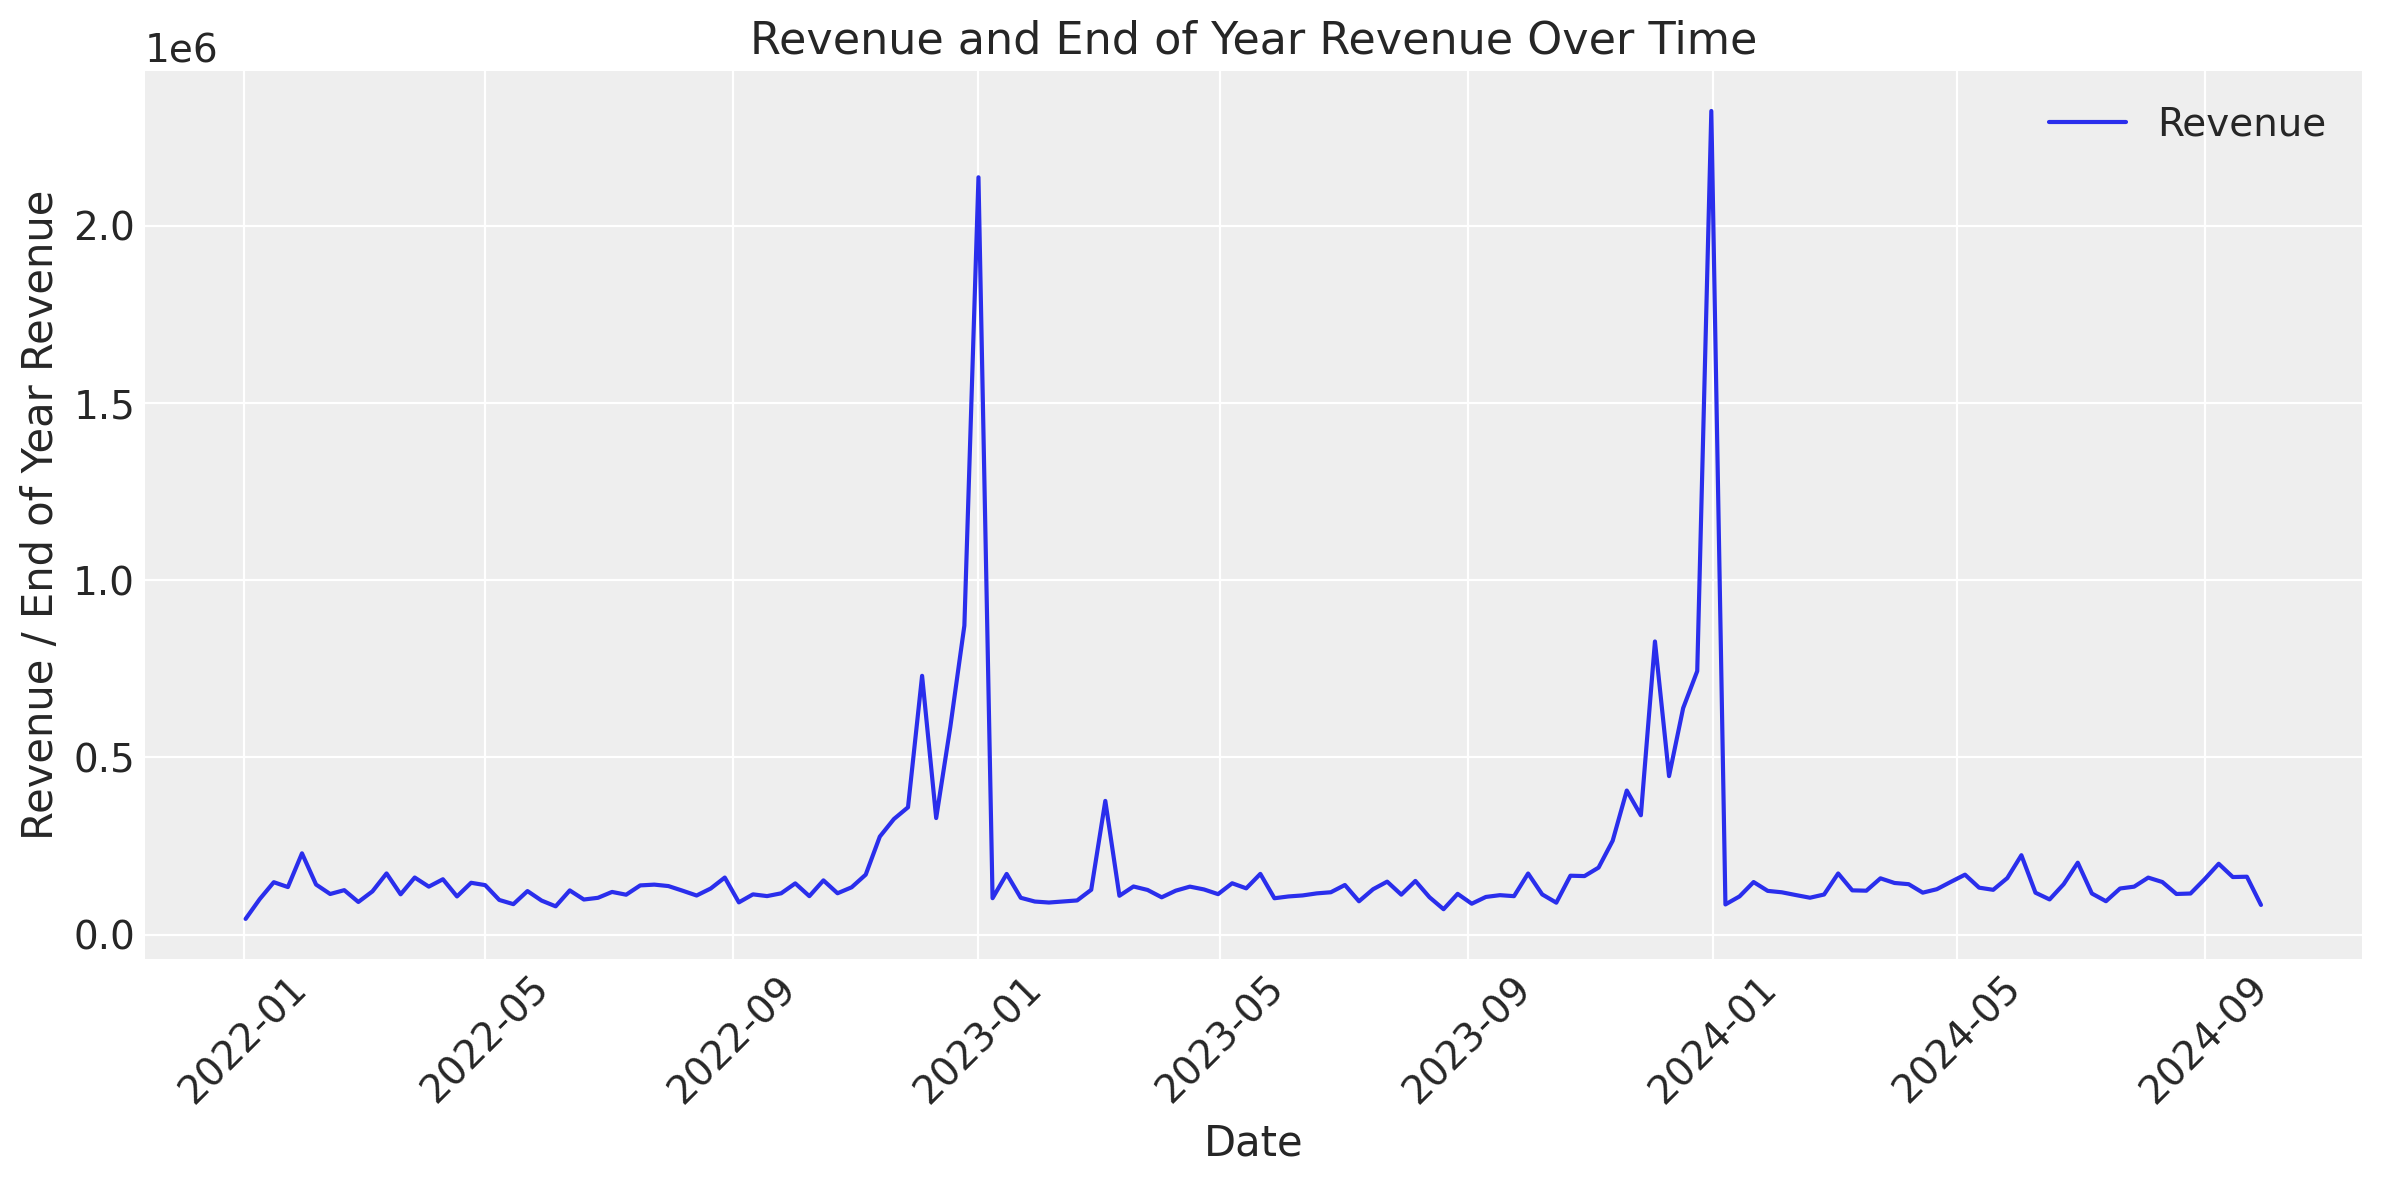

In [22]:
# prompt: generate chart with Date as x axis and revenue and end of year on y axis

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame as defined in the previous code

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Revenue'], label='Revenue')
#plt.plot(df['Date'], df['end_of_year'] * df['Revenue'].max(), label='End of Year Revenue', linestyle='--', marker='o') # Plot EOY Revenue
plt.xlabel('Date')
plt.ylabel('Revenue / End of Year Revenue')
plt.title('Revenue and End of Year Revenue Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              144 non-null    datetime64[ns]
 1   Bing_Branded_Impressions          144 non-null    float64       
 2   Bing_Branded_Spend                144 non-null    float64       
 3   Bing_NonBranded_Impressions       144 non-null    float64       
 4   Bing_NonBranded_Spend             144 non-null    float64       
 5   DM_Spend                          144 non-null    float64       
 6   DM_Impressions                    144 non-null    float64       
 7   Email_Impressions                 144 non-null    float64       
 8   Email_Spend                       144 non-null    float64       
 9   FB_Spend                          144 non-null    float64       
 10  FB_Impressions                    144 non-null    

In [24]:
#df_ = df.set_index('Date')
#input_df = df_[['Revenue', *[c for c in df_.columns if 'Impressions' in c], 'october', 'november', 'december',  ]]


In [25]:
df_ = df.set_index('Date')

spend_df = df_[['Revenue', *[c for c in df_.columns if 'Spend' in c], 'october', 'november', 'december', 'google_trend']]

In [26]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


df = spend_df.copy()
#df = input_df.copy()
df = df.reset_index()

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 144


In [27]:
data = df.copy()
X = data.drop("Revenue", axis=1)
y = data["Revenue"]

In [28]:
data.dtypes

,0
Date,datetime64[ns]
Revenue,float64
Bing_Branded_Spend,float64
Bing_NonBranded_Spend,float64
DM_Spend,float64
Email_Spend,float64
FB_Spend,float64
GoogleAds_Branded_Spend,float64
GoogleAds_NonBranded_Spend,float64
Programatic_Spend,float64


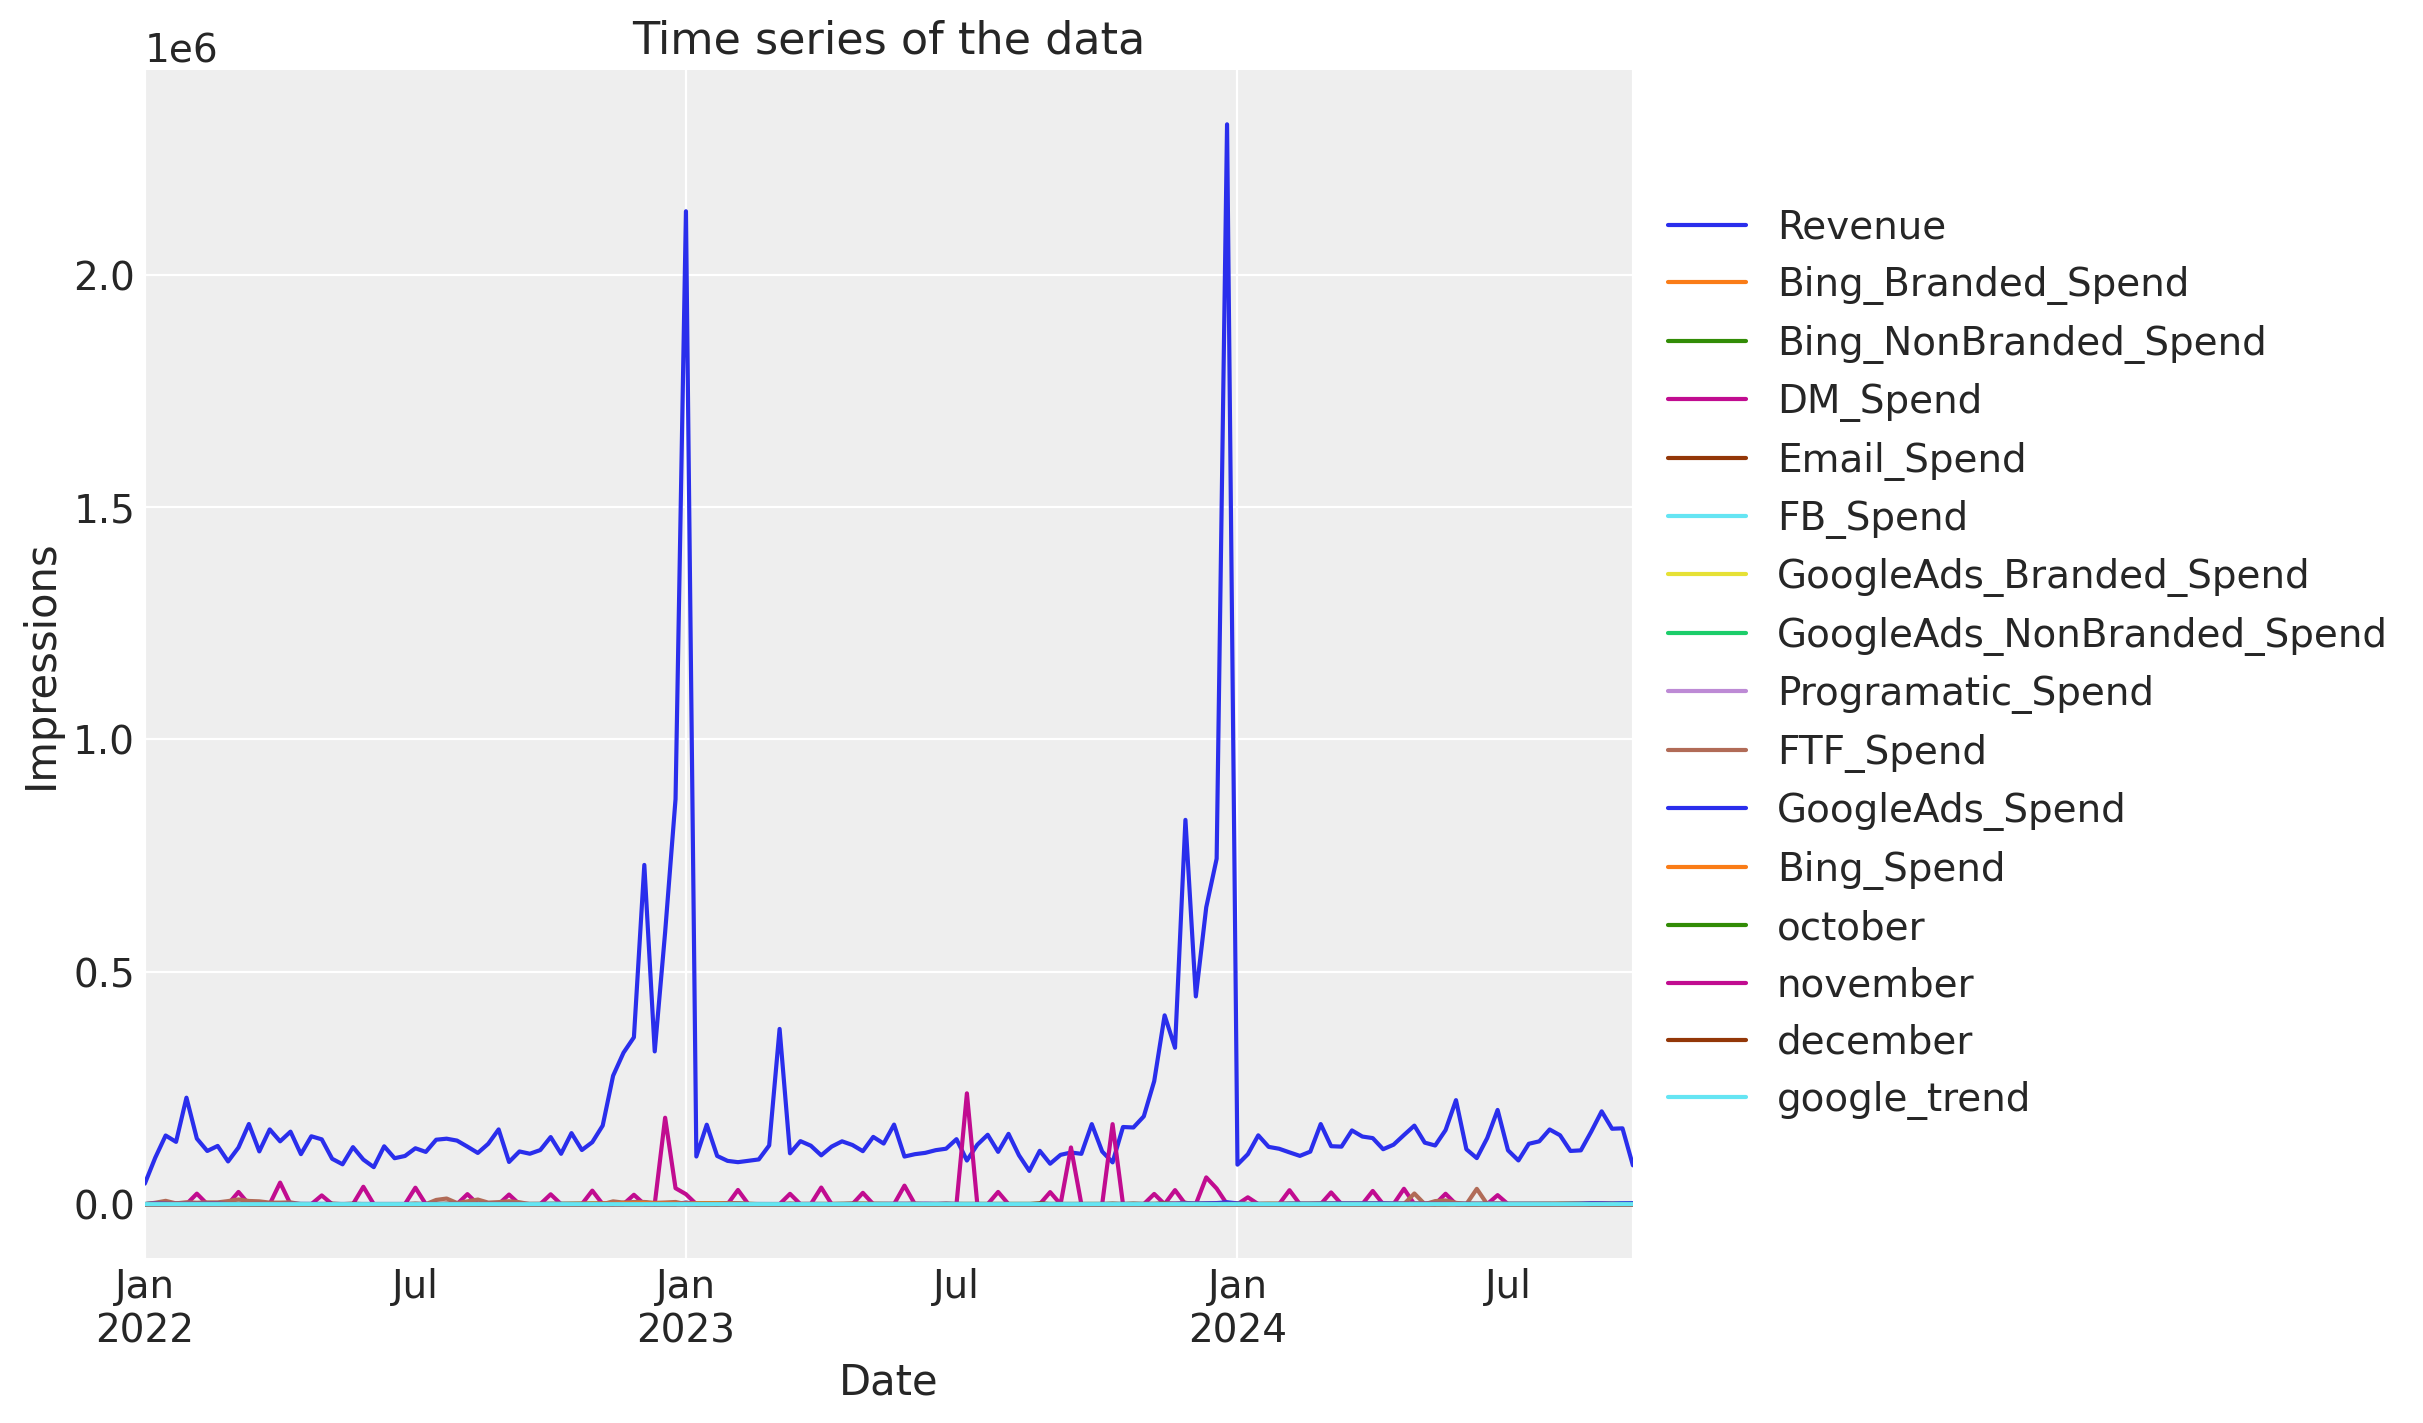

In [29]:
fig, ax = plt.subplots()
data.set_index("Date").plot(ax=ax)
ax.set_title("Time series of the data")
ax.set_ylabel("Impressions")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

In [30]:
from pymc_marketing.prior import Prior
import pymc_marketing.mmm as mmm

In [31]:
sampler_config = {"progressbar": True}

In [32]:
print(df.columns[df.columns.duplicated()].tolist())  # Lists all duplicated column names


[]


In [33]:
custom_config = {
    "intercept": Prior("HalfNormal", sigma=10),
    "saturation_beta": Prior(
        "Gamma",  sigma=5, dims="channel"
    ),
    "gamma_control": {
        "dist": "HalfNormal",
        "kwargs": { "sigma": 2.5}
    },
     "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": { "mu":0,"b": 2}
    },

    "saturation_lam": Prior("Gamma", alpha=4, beta=4, dims="channel"),
}


media_tvp_config = {
    "media_tvp_config": {
        "m": 50,  # Reduced number of basis functions from 50
        "L": 30,  # Reduced from 30
        "eta_lam": 2,  # Increased from 2 for stronger smoothing
        "ls_mu": 2,  # Reduced from 2
        "ls_sigma": 5,  # Reduced from 5
        "cov_func": None, #"exponential"  # Added covariance function for better regularization
    }
}

custom_config = {**custom_config, **media_tvp_config}

ch = ['Bing_Impressions', 'DM_Impressions', 'Email_Impressions',
       'FB_Impressions', 'GoogleAds_Impressions', 'Programatic_Impressions',
       'FTF_Impressions']

ch_spend = ['Bing_Spend', 'DM_Spend', 'Email_Spend',
       'FB_Spend', 'GoogleAds_Spend', 'Programatic_Spend',
       'FTF_Spend']

control_cols = ["october", "november", "december", "google_trend"]
#control_cols += [col for col in df.columns if col.startswith("month_")]
#control_cols += [col for col in df.columns if col.startswith("woy_")]

# or for weeks: if col.startswith("woy_")
print(control_cols)


mmm = MMM(
    model_config=custom_config,
    sampler_config={"progressbar": True},
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),  # Reduced from 12
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch_spend,
    control_columns=control_cols,
    yearly_seasonality=2,  # Reduced from 2
    #time_varying_media=False,
    #time_varying_intercept=False
)

['october', 'november', 'december', 'google_trend']


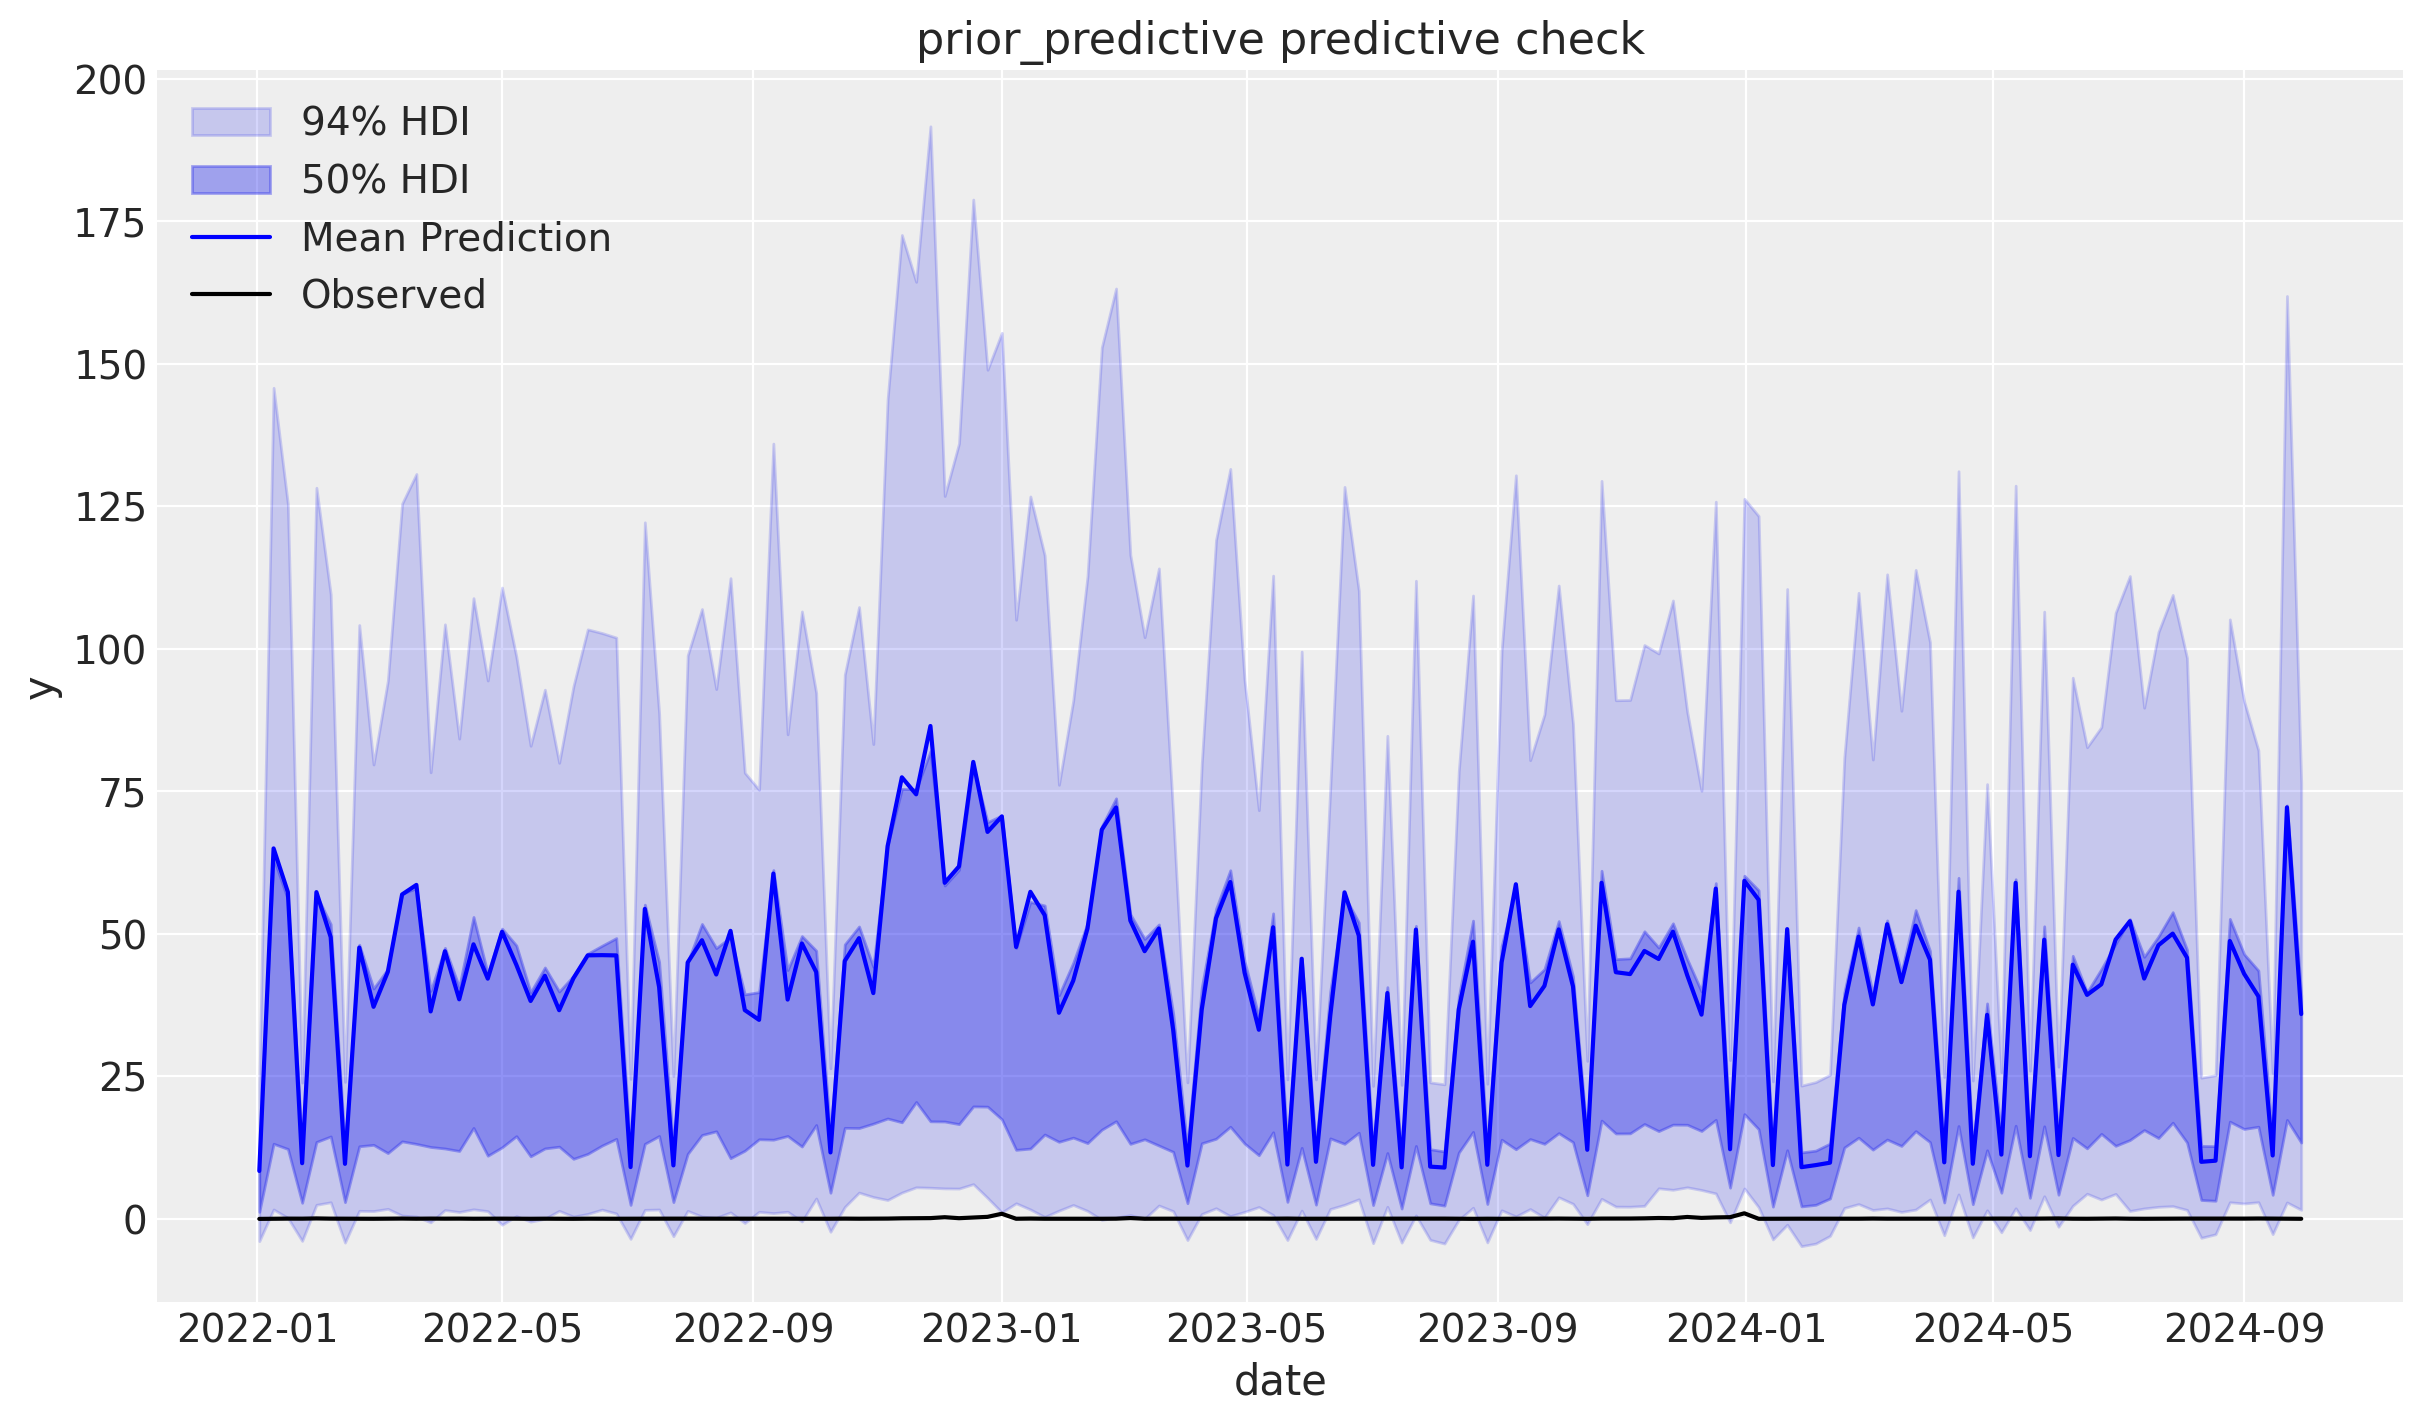

In [34]:
# Generate prior predictive samples
mmm.sample_prior_predictive(X, y, samples=6_000)

mmm.plot_prior_predictive();

In [35]:
mmm.fit(X=X, y=y, nuts_sampler="numpyro",target_accept=0.95, chains=4, draws=6_000, random_seed=rng)

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

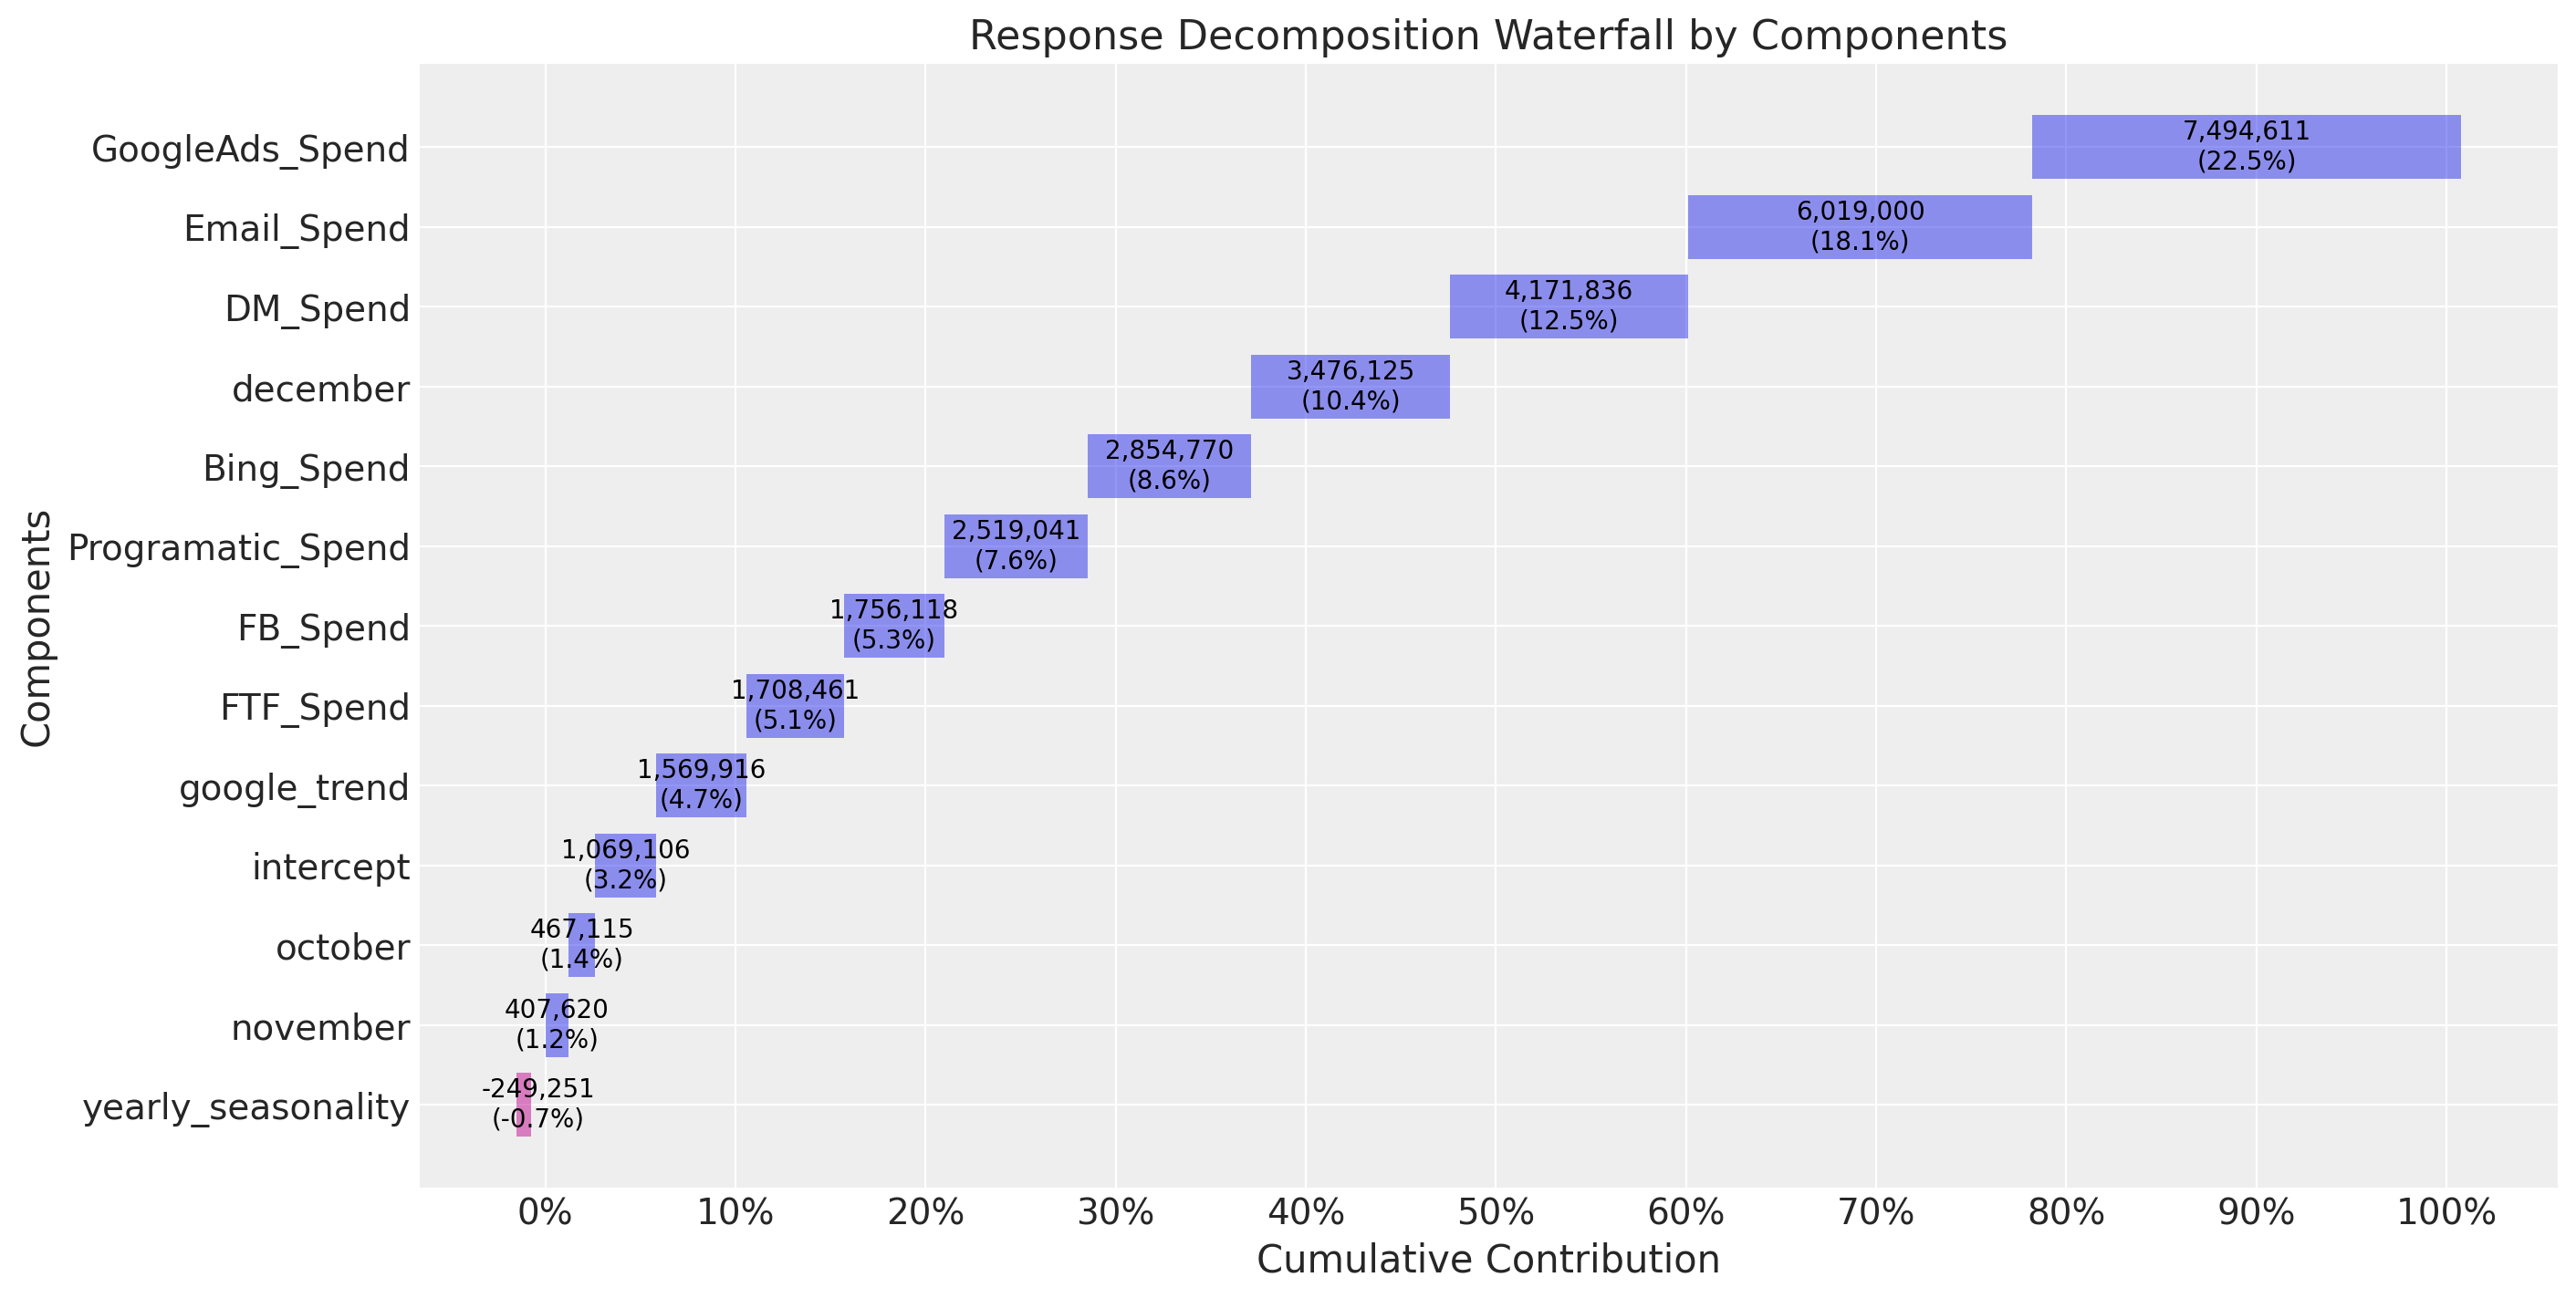

In [36]:
mmm.plot_waterfall_components_decomposition();

In [37]:
#X['end_of_year'] = X['end_of_year'].astype(int)

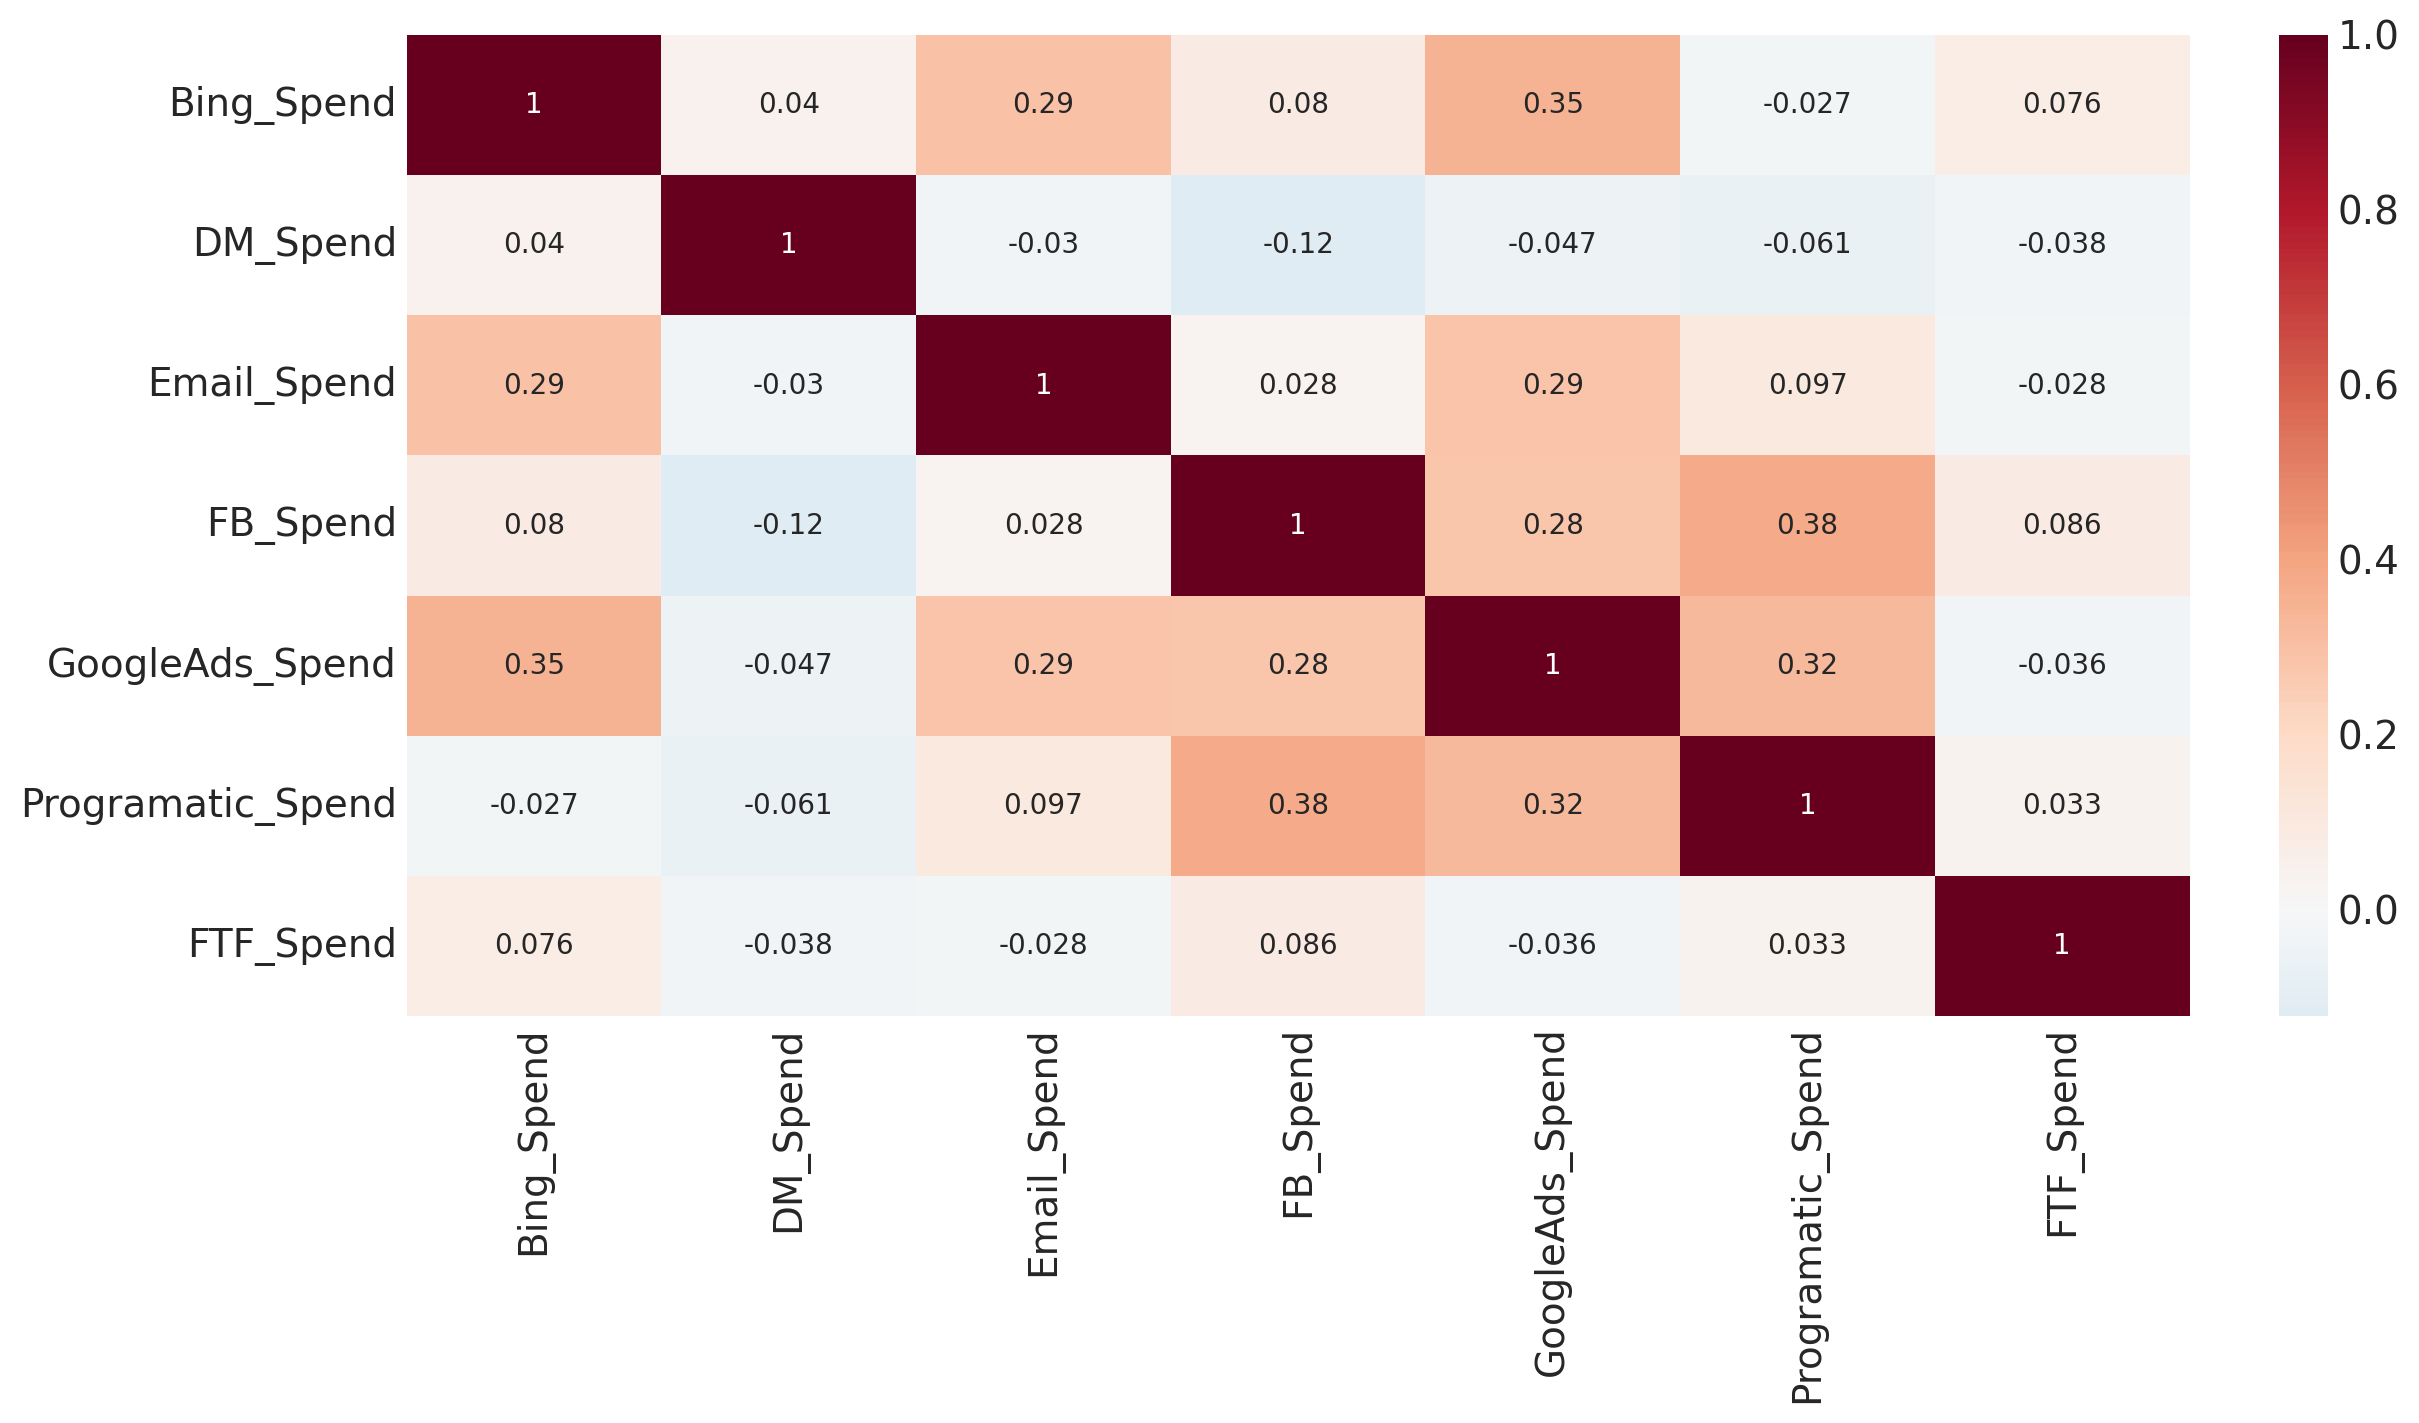

In [38]:
#checking for channel collinarity
corr = df[ch_spend].corr()
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0)
plt.show()


In [39]:
from sklearn.metrics import r2_score

def get_mape(mmm_):
    y_pred = mmm_.predict(X)  # Use the original X DataFrame with datetime 'Date'
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    print(f"MAPE: {mape}")

def get_r2(mmm_):
    y_pred = mmm_.predict(X)  # Use the original X DataFrame with datetime 'Date'
    r2 = r2_score(y, y_pred)
    return r2


In [40]:
print(get_mape(mmm))


Output()

MAPE: 63.63335712696766
None


In [41]:
print(get_r2(mmm))

Output()

0.5291424086653104


In [42]:
def get_posterior_check(mmm_):
  mmm_.sample_posterior_predictive(X, extend_idata=True, combined=True)
  mmm_.plot_posterior_predictive(original_scale=True);

Output()

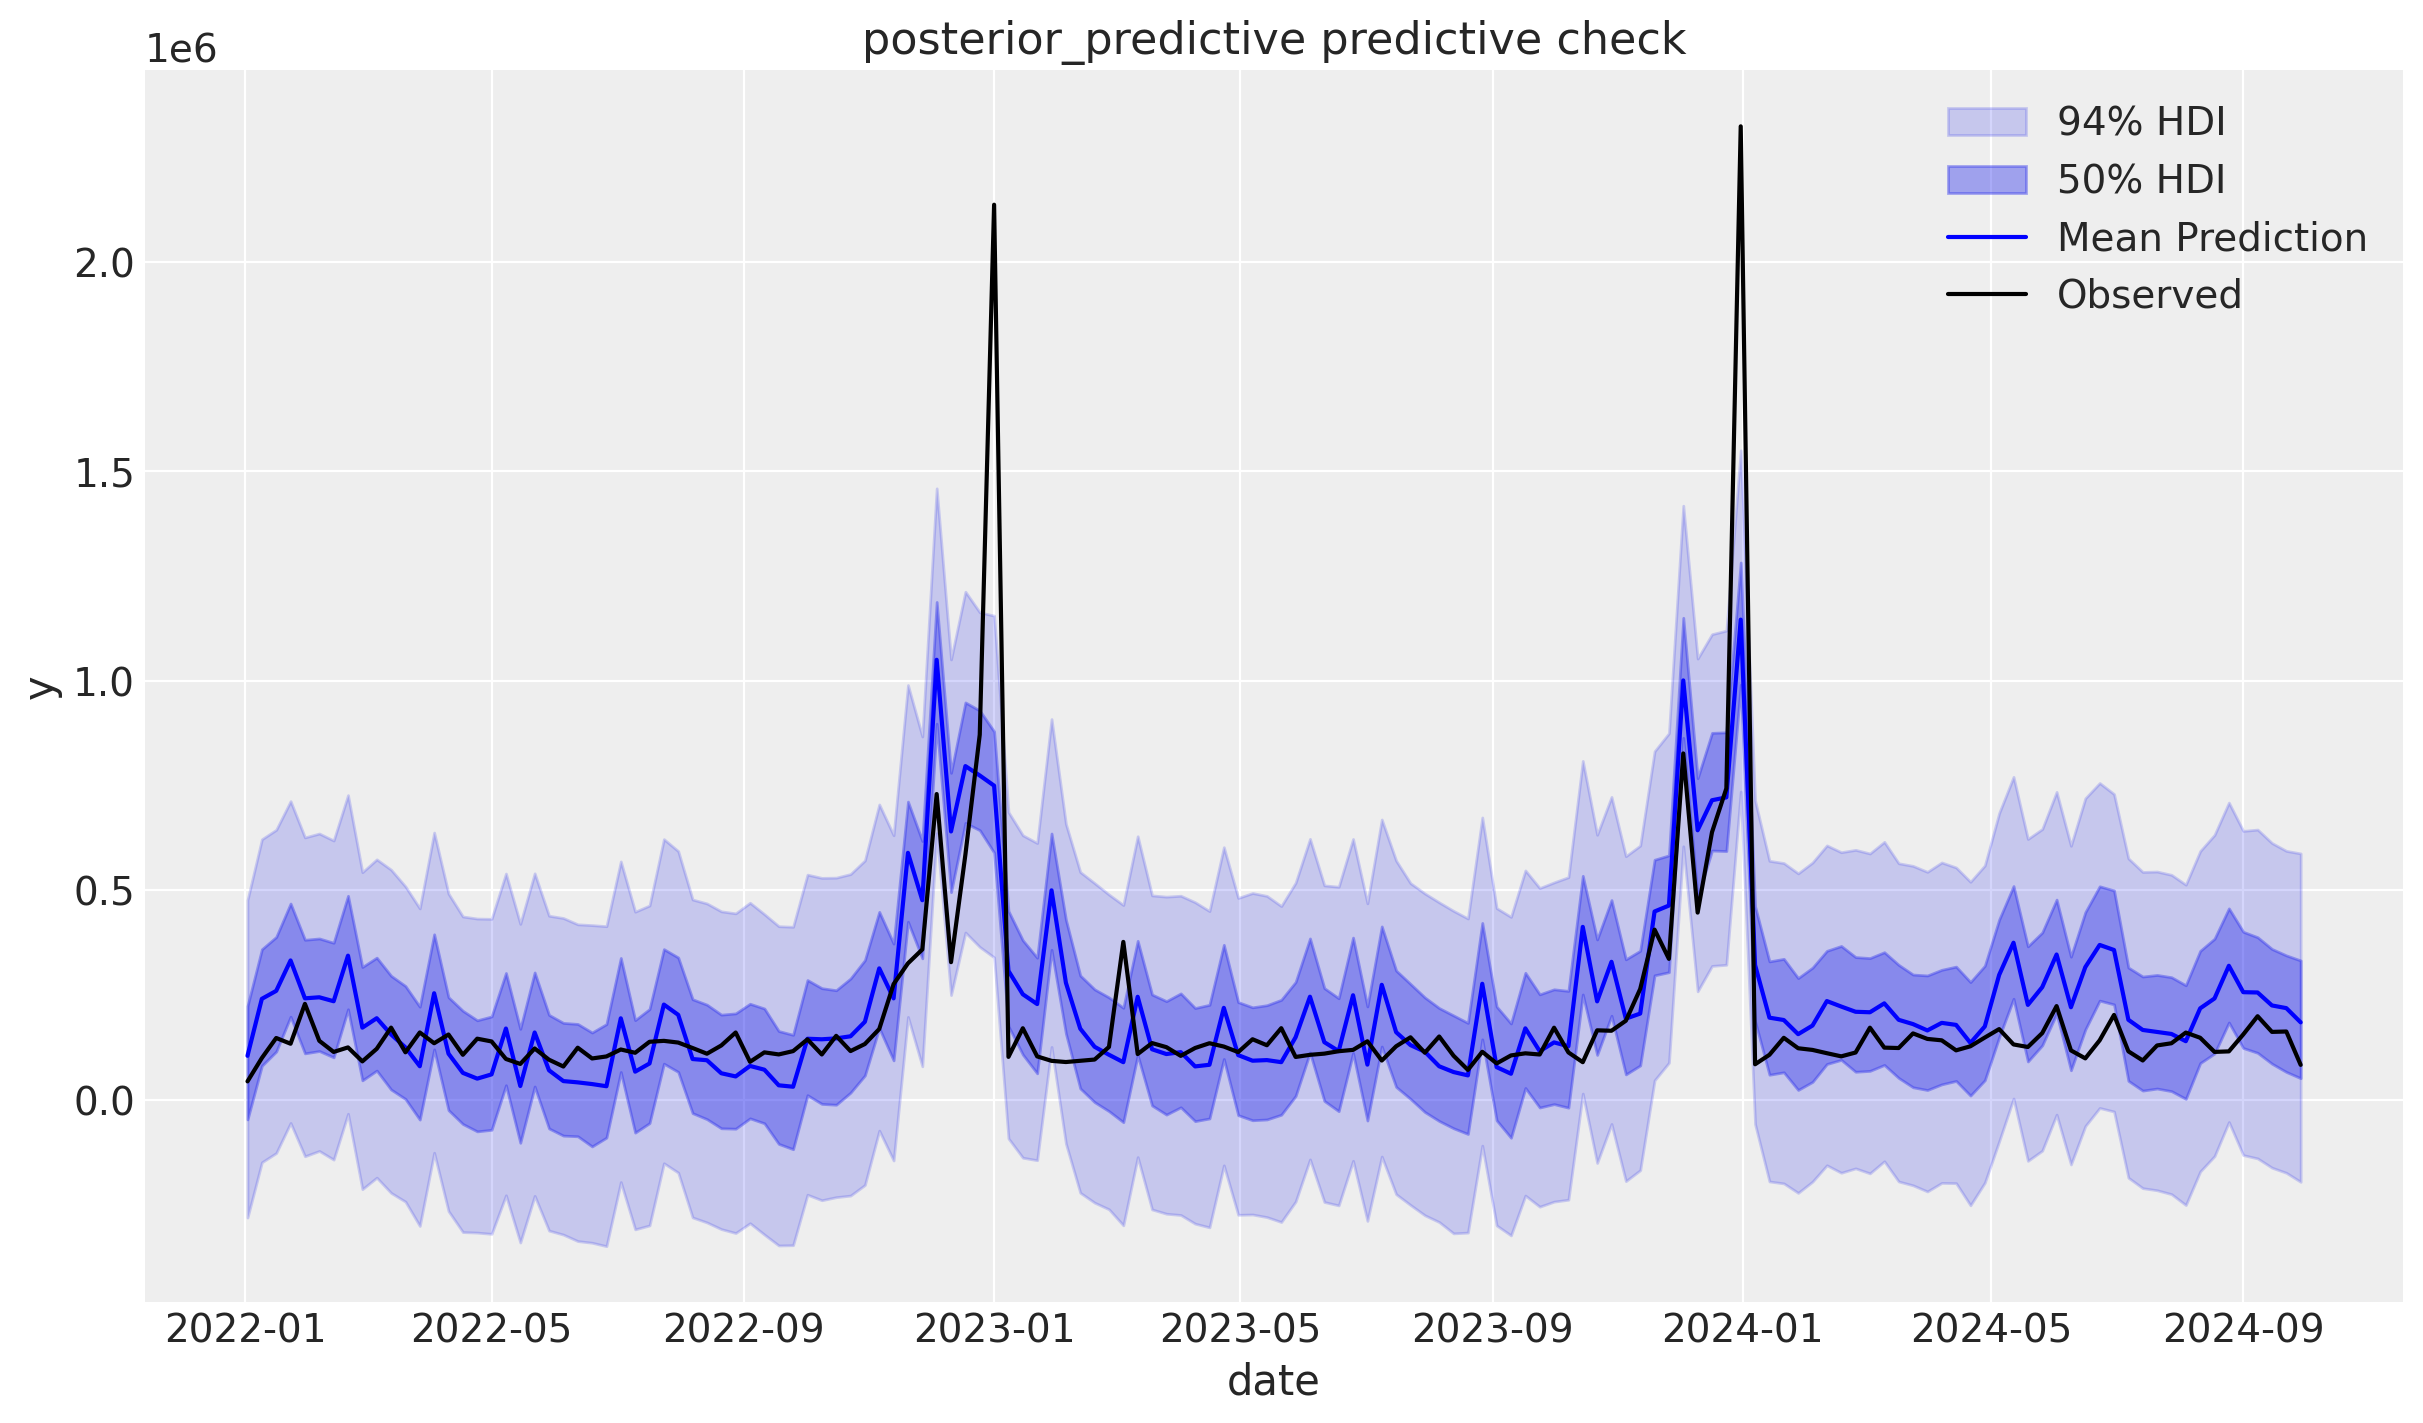

In [43]:
get_posterior_check(mmm)

In [44]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Simple MAPE function
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_metrics(y_true, y_pred):
    """
    Returns both MAPE and R^2 for the given true and predicted values
    """
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mape, r2



In [45]:
import pandas as pd

# Step 1: Peek at your Date column
print(df["Date"].head(10))

# Step 2: Try parsing with a guessed format or coerce
df["Date_parsed"] = pd.to_datetime(df["Date"],
                                   format="%d/%m/%Y",  # or remove this to infer automatically
                                   errors="coerce")

# Step 3: Check which rows didn't parse
invalid_rows = df[df["Date_parsed"].isna()]
if len(invalid_rows) > 0:
    print("Invalid date rows found:")
    print(invalid_rows["Date"])

# Step 4: Drop the original Date column BEFORE renaming
df = df.drop(columns=["Date"])  # Drop original Date column

# Step 5: Rename Date_parsed to Date
df = df.rename(columns={"Date_parsed": "Date"})

# Step 6: Confirm that the Date column is datetime64[ns]
df.info()  # Should show "Date" as datetime64[ns]


0   2022-01-02
1   2022-01-09
2   2022-01-16
3   2022-01-23
4   2022-01-30
5   2022-02-06
6   2022-02-13
7   2022-02-20
8   2022-02-27
9   2022-03-06
Name: Date, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Revenue                     144 non-null    float64       
 1   Bing_Branded_Spend          144 non-null    float64       
 2   Bing_NonBranded_Spend       144 non-null    float64       
 3   DM_Spend                    144 non-null    float64       
 4   Email_Spend                 144 non-null    float64       
 5   FB_Spend                    144 non-null    float64       
 6   GoogleAds_Branded_Spend     144 non-null    float64       
 7   GoogleAds_NonBranded_Spend  144 non-null    float64       
 8   Programatic_Spend           144 non-null    float64       
 9   FT

In [46]:
df = df.reset_index()  # Move Date back to a regular column



In [47]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")  # Ensure Date is datetime


print(df.info())  # Should show "Date" as the index, not a column
print(df.head())  # To visually verify


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   index                       144 non-null    int64         
 1   Revenue                     144 non-null    float64       
 2   Bing_Branded_Spend          144 non-null    float64       
 3   Bing_NonBranded_Spend       144 non-null    float64       
 4   DM_Spend                    144 non-null    float64       
 5   Email_Spend                 144 non-null    float64       
 6   FB_Spend                    144 non-null    float64       
 7   GoogleAds_Branded_Spend     144 non-null    float64       
 8   GoogleAds_NonBranded_Spend  144 non-null    float64       
 9   Programatic_Spend           144 non-null    float64       
 10  FTF_Spend                   144 non-null    float64       
 11  GoogleAds_Spend             144 non-null    float64       

In [52]:
ch = [
    'Bing_Spend',
    'DM_Spend',
    'Email_Spend',
    'FB_Spend',
    'GoogleAds_Spend',
    'Programatic_Spend',
    'FTF_Spend'
]
control_cols = [
    'october',  # or rename as needed
    'november',
    'december',
    'google_trend'   # your new trend variable
]


In [53]:
import pymc as pm
from pymc_marketing.mmm import MMM, GeometricAdstock, MichaelisMentenSaturation

def fit_and_evaluate_fold(
    df,
    date_col,
    train_start,
    train_end,
    test_start,
    test_end,
    channel_cols,
    control_cols,
    custom_config,
    rng,
    draws=2000,
    chains=2
):
    """
    Fits the MMM on [train_start : train_end] range,
    then predicts on [test_start : test_end].
    Returns model, predictions, MAPE, and R^2.
    """

    # 🔍 DEBUG 1: Print the DataFrame structure at function entry
    #print("🔍 DEBUG: Checking DataFrame at function entry:")
    #print(df.info())  # Shows column names and types
    #print("Columns:", df.columns.tolist())  # Lists column names
    #print("First few rows:\n", df.head())

    # Ensure Date is in datetime format
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # 🔍 DEBUG 2: Confirm Date column is still there after conversion
    if date_col not in df.columns:
        raise KeyError(f"🚨 Column '{date_col}' is missing from DataFrame!")

    # 1) Subset the data
    train_mask = (df[date_col] >= train_start) & (df[date_col] <= train_end)
    test_mask = (df[date_col] >= test_start) & (df[date_col] <= test_end)

    # 🔍 DEBUG 3: Check masks
    print(f"Train Start: {train_start}, Train End: {train_end}")
    print(f"Test Start: {test_start}, Test End: {test_end}")
    print("Train Mask:\n", train_mask.head())
    print("Test Mask:\n", test_mask.head())

    df_train = df.loc[train_mask].copy()
    df_test = df.loc[test_mask].copy()

    print(df_train.columns)
    print(df_test.columns)


    # 🔍 DEBUG 4: Check DataFrames after filtering
    print("🔍 DEBUG: df_train after filtering:\n", df_train.info())
    print("🔍 DEBUG: df_test after filtering:\n", df_test.info())

    # 2) Separate features (X) and target (y)
    X_train = df_train[["Date"] + channel_cols + control_cols]
    y_train = df_train["Revenue"]

    X_test = df_test[["Date"] + channel_cols + control_cols]
    y_test = df_test["Revenue"]


    # 3) Initialize the MMM with the same config as your main model
    mmm_fold = MMM(
        model_config=custom_config,
        sampler_config={"progressbar": True},
        date_column='Date',
        adstock=GeometricAdstock(l_max=8),
        saturation=MichaelisMentenSaturation(),
        channel_columns=channel_cols,
        control_columns=control_cols,
        yearly_seasonality=2,
        time_varying_media=True,
        time_varying_intercept=True
    )

    # 4) Fit the model on training data
    mmm_fold.fit(
        X=X_train,
        y=y_train,
        nuts_sampler="numpyro",
        target_accept=0.95,
        chains=chains,
        draws=draws,
        random_seed=rng
    )

    # 5) Predict on the test set
    y_pred_test = mmm_fold.predict(X_test)

    # 6) Compute metrics
    fold_mape, fold_r2 = get_metrics(y_test.values, y_pred_test)

    return mmm_fold, y_test, y_pred_test, fold_mape, fold_r2


In [50]:
#df["end_of_year"] = df["end_of_year"].astype(int)


KeyError: 'end_of_year'

In [54]:
folds = [
    # ---- 2022 Non‐Holiday ----
    {
        "name": "Fold A (Non‐Holiday 2022)",
        "train_start": "2022-01-01",
        "train_end":   "2022-03-31",   # or "2022-09-30" for more training
        "test_start":  "2022-04-01",
        "test_end":    "2022-10-31",
    },
    # ---- 2022 Holiday ----
    {
        "name": "Fold B (Holiday 2022)",
        "train_start": "2022-01-01",
        "train_end":   "2022-10-31",
        "test_start":  "2022-11-01",
        "test_end":    "2022-12-31",
    },
    # ---- 2023 Non‐Holiday ----
    {
        "name": "Fold C (Non‐Holiday 2023)",
        "train_start": "2022-01-01",
        "train_end":   "2022-12-31",   # or "2023-03-31"
        "test_start":  "2023-04-01",
        "test_end":    "2023-10-31",
    },
    # ---- 2023 Holiday ----
    {
        "name": "Fold D (Holiday 2023)",
        "train_start": "2022-01-01",
        "train_end":   "2023-10-31",
        "test_start":  "2023-11-01",
        "test_end":    "2023-12-31",
    }
]


In [55]:
results = []
for fold_info in folds:
    print(f"Running {fold_info['name']}...")

    mmm_fold, y_test, y_pred_test, fold_mape, fold_r2 = fit_and_evaluate_fold(
        df=df,
        date_col="Date",
        train_start=fold_info["train_start"],
        train_end=fold_info["train_end"],
        test_start=fold_info["test_start"],
        test_end=fold_info["test_end"],
        channel_cols=ch,
        control_cols=control_cols,
        custom_config=custom_config,
        rng=np.random.default_rng(42),
        draws=1000,   # can adjust up/down
        chains=2
    )

    results.append({
        "Fold": fold_info["name"],
        "Train_Period": f"{fold_info['train_start']} to {fold_info['train_end']}",
        "Test_Period":  f"{fold_info['test_start']} to {fold_info['test_end']}",
        "MAPE": fold_mape,
        "R2":   fold_r2
    })

pd.DataFrame(results)


Running Fold A (Non‐Holiday 2022)...
Train Start: 2022-01-01, Train End: 2022-03-31
Test Start: 2022-04-01, Test End: 2022-10-31
Train Mask:
 0    True
1    True
2    True
3    True
4    True
Name: Date, dtype: bool
Test Mask:
 0    False
1    False
2    False
3    False
4    False
Name: Date, dtype: bool
Index(['index', 'Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend',
       'DM_Spend', 'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend',
       'GoogleAds_Spend', 'Bing_Spend', 'october', 'november', 'december',
       'google_trend', 'Date'],
      dtype='object')
Index(['index', 'Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend',
       'DM_Spend', 'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend',
       'GoogleAds_Spend', 'Bing_Spend', 'october', 'november', 'december',
       'google_trend', 'Date'],
      dtype='object')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Running Fold B (Holiday 2022)...
Train Start: 2022-01-01, Train End: 2022-10-31
Test Start: 2022-11-01, Test End: 2022-12-31
Train Mask:
 0    True
1    True
2    True
3    True
4    True
Name: Date, dtype: bool
Test Mask:
 0    False
1    False
2    False
3    False
4    False
Name: Date, dtype: bool
Index(['index', 'Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend',
       'DM_Spend', 'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend',
       'GoogleAds_Spend', 'Bing_Spend', 'october', 'november', 'december',
       'google_trend', 'Date'],
      dtype='object')
Index(['index', 'Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend',
       'DM_Spend', 'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend',
       'GoogleAds_Spend', 'Bing_Spend', 'october', 'november', 'december',
       'google_trend', 'Date'],
      dtype='object')
<cl

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR:pymc.stats.convergence:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Running Fold C (Non‐Holiday 2023)...
Train Start: 2022-01-01, Train End: 2022-12-31
Test Start: 2023-04-01, Test End: 2023-10-31
Train Mask:
 0    True
1    True
2    True
3    True
4    True
Name: Date, dtype: bool
Test Mask:
 0    False
1    False
2    False
3    False
4    False
Name: Date, dtype: bool
Index(['index', 'Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend',
       'DM_Spend', 'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend',
       'GoogleAds_Spend', 'Bing_Spend', 'october', 'november', 'december',
       'google_trend', 'Date'],
      dtype='object')
Index(['index', 'Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend',
       'DM_Spend', 'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend',
       'GoogleAds_Spend', 'Bing_Spend', 'october', 'november', 'december',
       'google_trend', 'Date'],
      dtype='object')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR:pymc.stats.convergence:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Running Fold D (Holiday 2023)...
Train Start: 2022-01-01, Train End: 2023-10-31
Test Start: 2023-11-01, Test End: 2023-12-31
Train Mask:
 0    True
1    True
2    True
3    True
4    True
Name: Date, dtype: bool
Test Mask:
 0    False
1    False
2    False
3    False
4    False
Name: Date, dtype: bool
Index(['index', 'Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend',
       'DM_Spend', 'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend',
       'GoogleAds_Spend', 'Bing_Spend', 'october', 'november', 'december',
       'google_trend', 'Date'],
      dtype='object')
Index(['index', 'Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend',
       'DM_Spend', 'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend',
       'GoogleAds_Spend', 'Bing_Spend', 'october', 'november', 'december',
       'google_trend', 'Date'],
      dtype='object')
<cl

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Output()

,Fold,Train_Period,Test_Period,MAPE,R2
0,Fold A (Non‐Holiday 2022),2022-01-01 to 2022-03-31,2022-04-01 to 2022-10-31,663.675710,-1787.923601
1,Fold B (Holiday 2022),2022-01-01 to 2022-10-31,2022-11-01 to 2022-12-31,88.115597,-0.595901
2,Fold C (Non‐Holiday 2023),2022-01-01 to 2022-12-31,2023-04-01 to 2023-10-31,1453.744578,-5028.041310
3,Fold D (Holiday 2023),2022-01-01 to 2023-10-31,2023-11-01 to 2023-12-31,48.236776,-0.859633


In [ ]:
df_res = df[['Date']]
df_res['y'] = y
df_res['y_pred'] = mmm.predict(X)

In [ ]:
df_res

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_res['Date'], df_res['y'], label='y')
plt.plot(df['Date'], df_res['y_pred'], label='y_pred', linestyle='--', marker='o') # Plot EOY Revenue
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Model Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
